## DUSP1 smiFISH Classification Workflow

This notebook processes experimental data from BigFish and CellProperties CSV files to classify DUSP1 smiFISH spots. Below is an outline of the workflow:

### Input:
- BigFish CSV files
- CellProperties CSV files

### Workflow Steps:
1. **Merge Experimental Data**  
    Combine data from the input CSV files for unified analysis.

2. **Signal-to-Noise Ratio (SNR) Analysis**  
    Perform SNR analysis to classify and filter spots based on signal quality.

3. **Measurement Analysis**  
    Conduct measurement analysis to extract relevant features from the data.

4. **Data Merging**  
    Merge all processed data into a single dataset for further analysis.

5. **Create Training Spot Crops (11px x 11px)**  
    Generate training data for machine learning models:
    - Select 1000 spots from each `h5_idx`, ensuring variation across cells and fields of view (FOVs).
    - Use the DUSP1 Display Manager to safely load spot channel images.
    - Perform max projection of images along the z-axis to create 2D (x, y) representations.
    - Extract 11px x 11px crops centered on each spot.
    - Rescale intensity for visualization purposes.
    - Display 100 sample spot crops for quality inspection before saving all crops to a directory.

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask.array as da
import os
import sys
import logging
import seaborn as sns
import datetime

# Today's date
today = datetime.date.today()
# Format date as 'Mar21' (for example)
date_str = today.strftime("%b%d")

logging.getLogger('matplotlib.font_manager').disabled = True
numba_logger = logging.getLogger('numba')
numba_logger.setLevel(logging.WARNING)

matplotlib_logger = logging.getLogger('matplotlib')
matplotlib_logger.setLevel(logging.WARNING)

src_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
print(src_path)
sys.path.append(src_path)

from src.Analysis_DUSP1_v2 import DUSP1AnalysisManager, SNRAnalysis, DUSP1Measurement, DUSP1DisplayManager, SpotCropSampler

/Users/ericron/Desktop/AngelFISH


In [ ]:
loc = None
log_location = r'/Volumes/share/Users/Eric/GR_DUSP1_reruns'
save_dir = r'/Volumes/share/Users/Eric/DUSP1_SpotCrops'

# Define Thresholds
abs_threshold = 4
mg_threshold = 3

    # DUSP1 Replica D 3hr 100nM time-sweep R1

In [ ]:
am = DUSP1AnalysisManager(location=loc, log_location=log_location, mac=True) 
am.select_analysis('DUSP1_D_Final')

spots_df = am.select_datasets("spotresults", dtype="dataframe")
clusters_df = am.select_datasets("clusterresults", dtype="dataframe")
props_df = am.select_datasets("cell_properties", dtype="dataframe")

snr_df = SNRAnalysis(spots_df, props_df, clusters_df, abs_threshold=abs_threshold, mg_threshold=mg_threshold)

merged_spots_df, merged_clusters_df, merged_cellprops_df = snr_df.get_results()

# Create an instance of the DUSP1Measurement class.
dusp = DUSP1Measurement(merged_spots_df, merged_clusters_df, merged_cellprops_df)

# Process the data with a chosen threshold method
cell_level_results = dusp.measure(abs_threshold=abs_threshold, mg_threshold=mg_threshold)

# Add replica level unique IDs for 'unique_cell_id', 'unique_spot_id', and 'unique_cluster_id'
# Get number of digits in the max unique_cell_id
max_id = merged_cellprops_df['unique_cell_id'].max()
num_digits = len(str(max_id))

# Calculate multiplier to add a '1' followed by the right number of zeroes - prefix is specific for each experiment (e.g., repD:1, repE:2, etc.)
rep_prefix = 10
prefix = rep_prefix ** num_digits  # e.g., if max_id = 30245 → prefix = 100000

# Apply prefix to all related DataFrames
merged_spots_df['unique_cell_id'] += prefix
merged_clusters_df['unique_cell_id'] += prefix
merged_cellprops_df['unique_cell_id'] += prefix
cell_level_results['unique_cell_id'] += prefix

# Repeat for unique_spot_id and unique_cluster_id
max_spot_id = merged_spots_df['unique_spot_id'].max()
spot_prefix = rep_prefix ** len(str(max_spot_id))
merged_spots_df['unique_spot_id'] += spot_prefix

max_cluster_id = merged_clusters_df['unique_cluster_id'].max()
cluster_prefix = rep_prefix ** len(str(max_cluster_id))
merged_clusters_df['unique_cluster_id'] += cluster_prefix

# Save all results to CSV
rep_string = 'DUSP1_D_Final'
output_dir = '/Users/ericron/Desktop/AngelFISH/Publications/Ron_2024/Classification'
os.makedirs(output_dir, exist_ok=True)
cell_level_results.to_csv(os.path.join(output_dir, f"{rep_string}_cell_level_results_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_spots_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_spots_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_clusters_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_clusters_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)
merged_cellprops_df.to_csv(os.path.join(output_dir, f"{rep_string}_merged_cellprops_df_MG{mg_threshold}_Abs{abs_threshold}_{date_str}.csv"), index=False)

In [ ]:
# load in the CSVs

cell_level_results = pd.read_csv('/Users/ericron/Desktop/AngelFISH/Publications/Ron_2024/Classification/DUSP1_D_Final_cell_level_results_MG3_Abs4_Apr22.csv')
merged_spots_df = pd.read_csv('/Users/ericron/Desktop/AngelFISH/Publications/Ron_2024/Classification/DUSP1_D_Final_merged_spots_df_MG3_Abs4_Apr22.csv')
merged_clusters_df = pd.read_csv('/Users/ericron/Desktop/AngelFISH/Publications/Ron_2024/Classification/DUSP1_D_Final_merged_clusters_df_MG3_Abs4_Apr22.csv')
merged_cellprops_df = pd.read_csv('/Users/ericron/Desktop/AngelFISH/Publications/Ron_2024/Classification/DUSP1_D_Final_merged_cellprops_df_MG3_Abs4_Apr22.csv')

In [ ]:
# instantiate sampler
sampler = SpotCropSampler(
    spots_df=merged_spots_df,
    clusters_df=merged_clusters_df,
    cellprops_df=merged_cellprops_df,
    mount_prefix="/Volumes/share"
)

# # — TEST RUN: only 3 displays, no files written —
# crops, meta = sampler.run(
#     save_dir=save_dir,
#     display=3,
#     save_individual=False,
#     save_summary=False,
#     pad=5,
#     cells_per_quad=1,
#     spots_per_cell=20,
#     spotChannel=0
# )

# choose a prefix for this experiment
prefix = "DUSP1_D_Final_MG3_Abs4"

# full run, no per-spot files, but summary files with prefix
crops, meta = sampler.run(
    save_dir=save_dir,
    display=0,
    save_individual=False,
    save_summary=True,
    file_prefix=prefix,
    pad=3,
    cells_per_quad=1,
    spots_per_cell=20,
    spotChannel=0
)

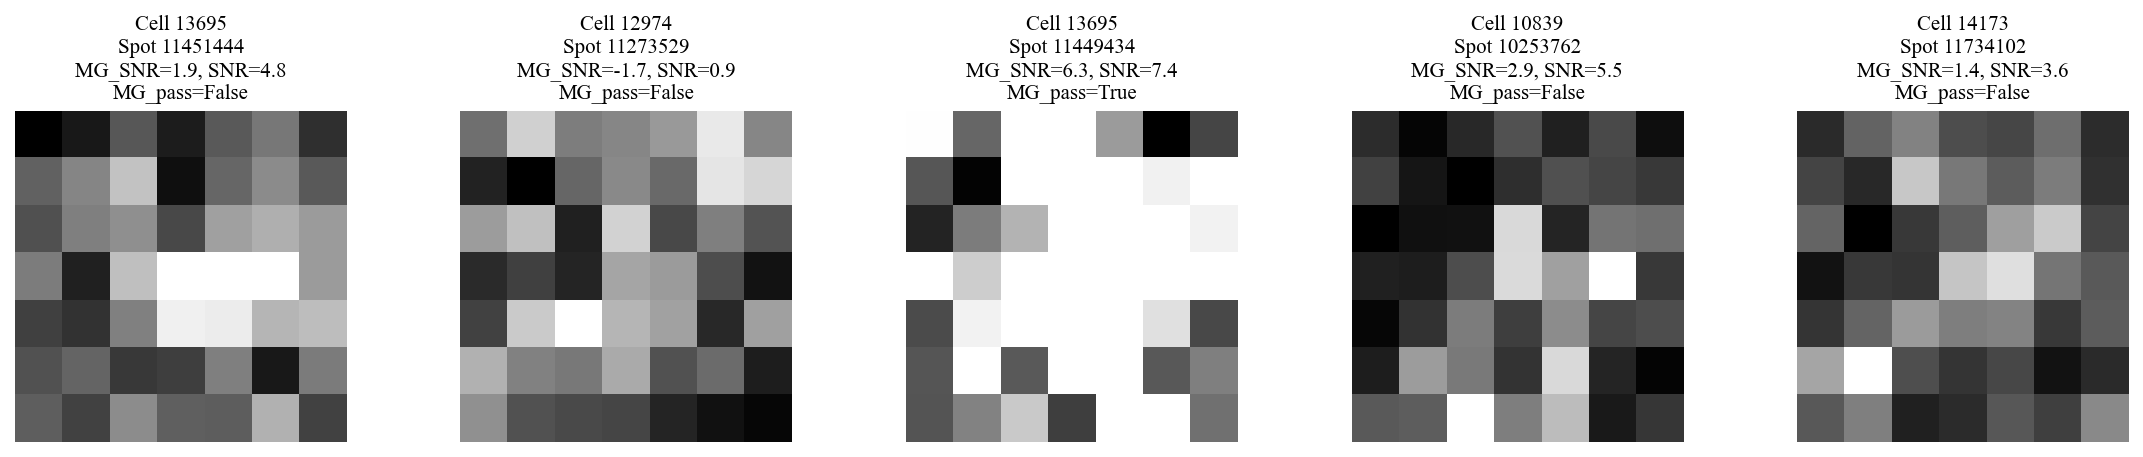

In [ ]:
# Directory where you saved the summary files
save_dir = "/Volumes/share/Users/Eric/DUSP1_SpotCrops"

# 1) Load the data
crops = np.load(os.path.join(save_dir, f"{prefix}_all_crops.npy"))  # shape: (N, 7, 7)
meta  = pd.read_csv(os.path.join(save_dir, f"{prefix}_all_crop_metadata.csv"))

# 2) Choose a few random examples (up to 5)
num_examples = min(5, len(crops))
indices = np.random.choice(len(crops), size=num_examples, replace=False)

# 3) Display them
fig, axes = plt.subplots(1, num_examples, figsize=(num_examples * 3, 3))
for ax, idx in zip(axes, indices):
    patch = crops[idx]
    info  = meta.iloc[idx]
    
    ax.imshow(patch, cmap='gray')
    ax.set_title(
        f"Cell {info.unique_cell_id}\n"
        f"Spot {info.unique_spot_id}\n"
        f"MG_SNR={info.MG_SNR:.1f}, SNR={info.snr:.1f}\n"
        f"MG_pass={info.MG_pass}"
    )
    ax.axis('off')

plt.tight_layout()
plt.show()

In [5]:
meta['h5_idx'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

    # DUSP1 Replica E 3hr 100nM time-sweep R2

    # DUSP1 Replica F 3hr 100nM time-sweep R3

    # DUSP1 Replica M 3hr 100nM time-sweep Partial

    # DUSP1 Replica N 3hr 100nM time-sweep Partial